In [1]:
# import library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np 

In [2]:
df = pd.read_csv('data/data.csv')

# I. Exploratory Data Analysis

## 1. Summary statistics 

In [3]:
# Check number of columns and rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Gender           2000 non-null   int64
 1   Marital Status   2000 non-null   int64
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int64
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int64
 6   Settlement Size  2000 non-null   int64
dtypes: int64(7)
memory usage: 109.5 KB


In [4]:
# Define categorical and numeric columns
categorical_columns = ['Gender', 'Marital Status', 'Education', 'Occupation', 'Settlement Size']
numeric_columns = ['Age','Income']

In [5]:
## Summary statistics
df.describe().loc[['count', 'mean', '50%', 'min', 'max']].rename(index={'50%': 'median'})

,Gender,Marital Status,Age,Education,Income,Occupation,Settlement Size
count,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.000
mean,0.6045,0.5005,40.8235,1.4565,137516.1965,0.6125,0.834
median,1.0000,1.0000,40.0000,1.0000,133004.0000,1.0000,0.000
min,0.0000,0.0000,20.0000,0.0000,35832.0000,0.0000,0.000
max,1.0000,1.0000,76.0000,3.0000,309364.0000,2.0000,2.000


## 2. Data visualization

### 2.1. Distribution of Age and Income

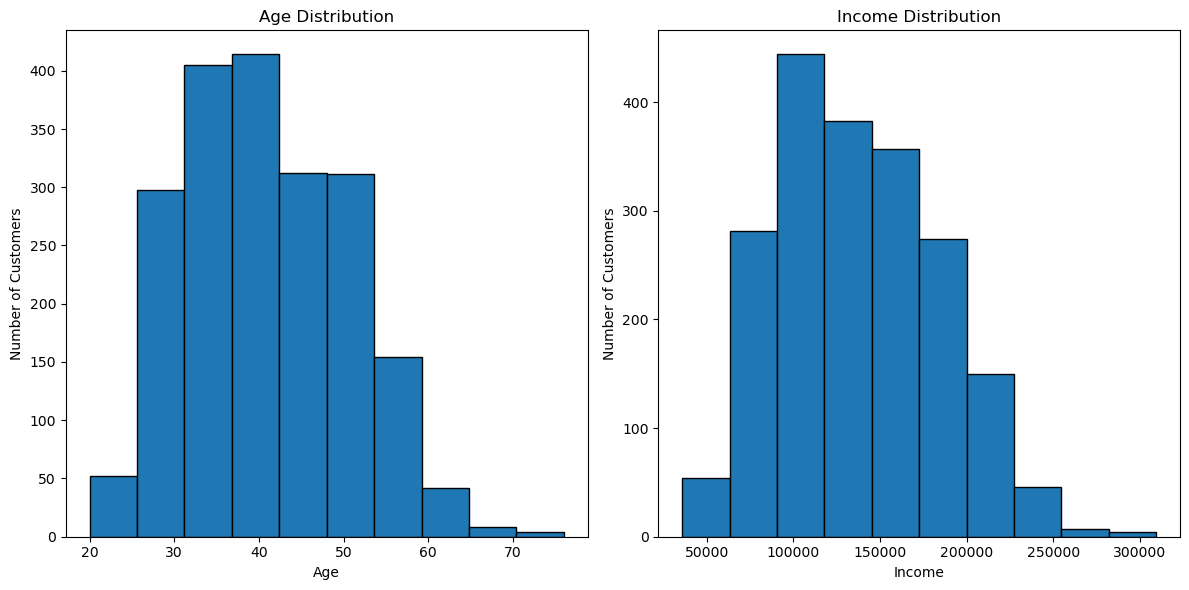

In [6]:
# Create a figure with subplots
plt.figure(figsize=(12, 6))

# Plot histogram for Age
plt.subplot(1, 2, 1)
plt.hist(df['Age'], bins=10, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.title('Age Distribution')

# Plot histogram for Income
plt.subplot(1, 2, 2)
plt.hist(df['Income'], bins=10, edgecolor='black')
plt.xlabel('Income')
plt.ylabel('Number of Customers')
plt.title('Income Distribution')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 2.2. Distribution of categorical variables

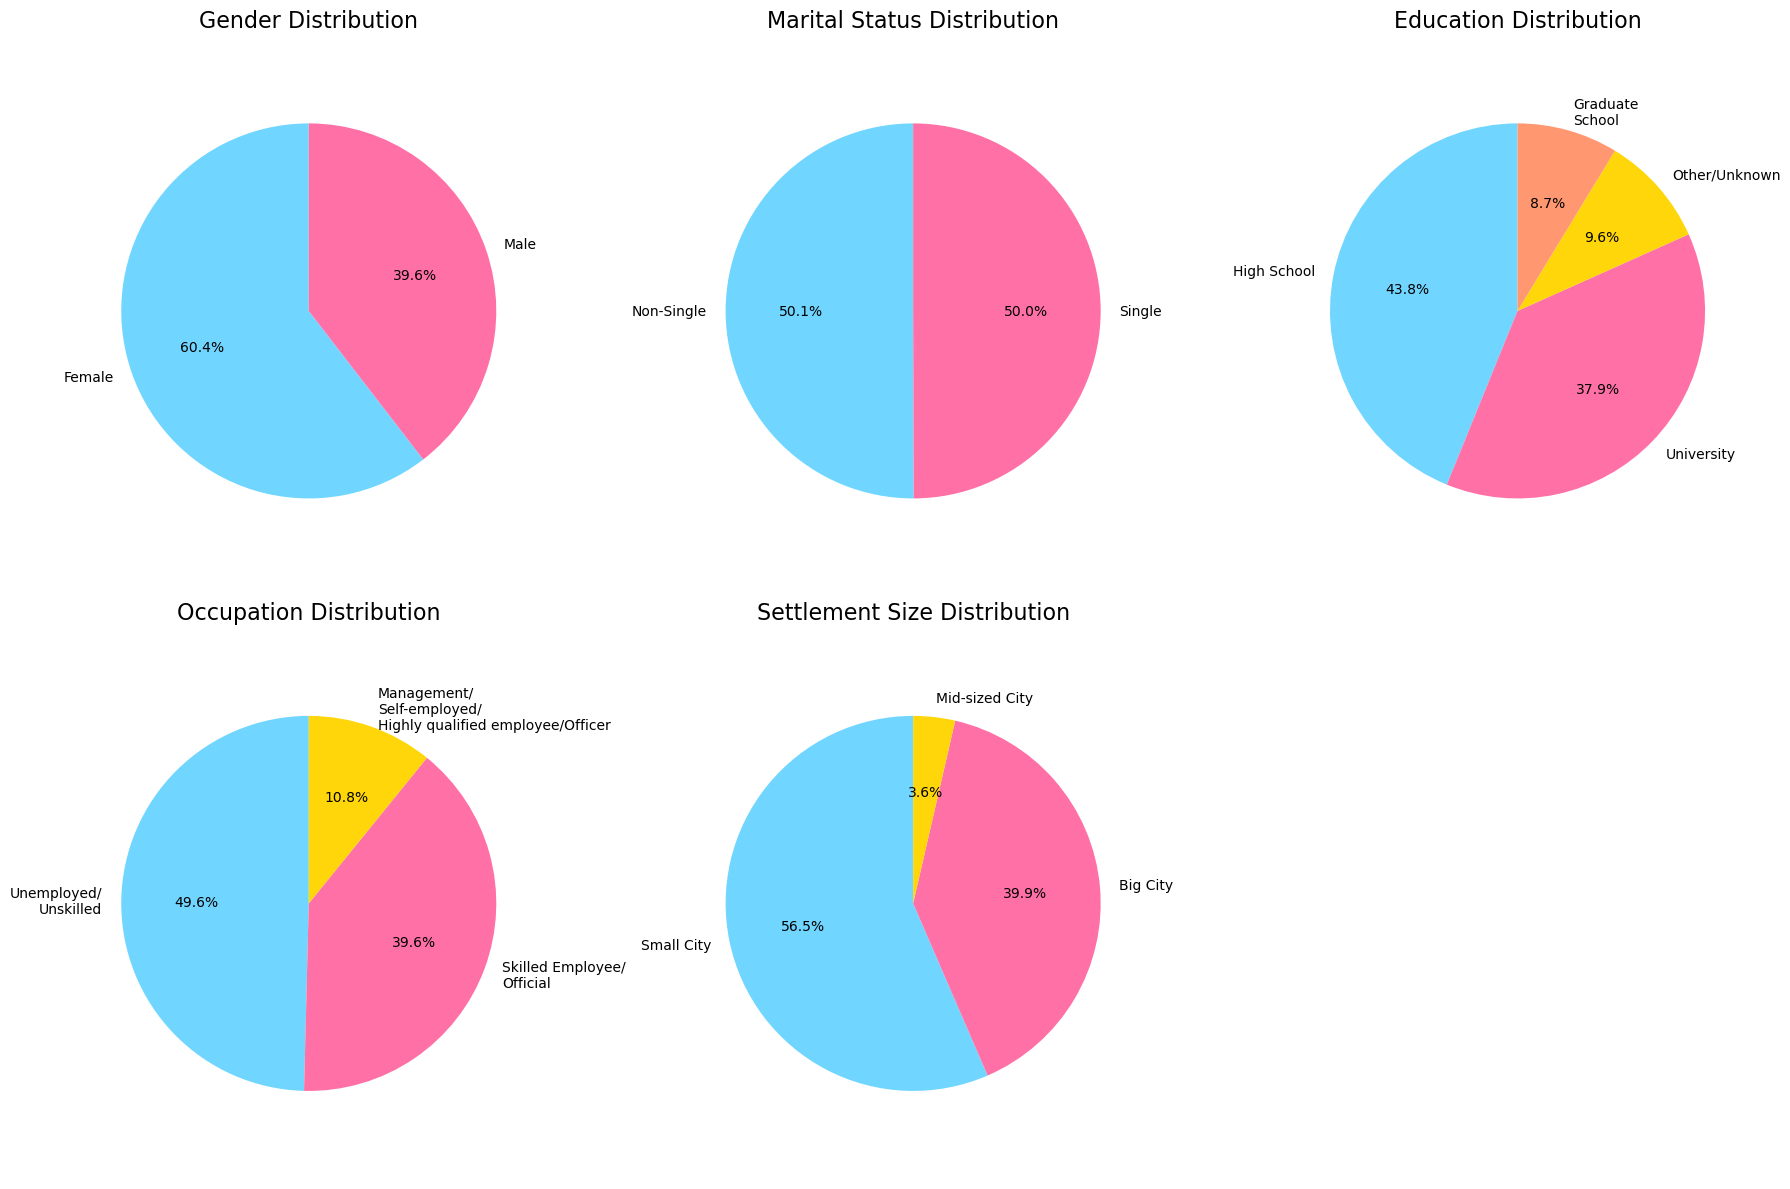

In [7]:
# Define the mappings for each category
mappings = {
    'Gender': {0: 'Male', 1: 'Female'},
    'Marital Status': {0: 'Single', 1: 'Non-Single'},
    'Education': {0: 'Other/Unknown', 1: 'High School', 2: 'University', 3: 'Graduate\nSchool'},
    'Occupation': {0: 'Unemployed/\nUnskilled', 1: 'Skilled Employee/\nOfficial', 2: 'Management/\nSelf-employed/\nHighly qualified employee/Officer'},
    'Settlement Size': {0: 'Small City', 1: 'Mid-sized City', 2: 'Big City'}
}

# Set up a 2x3 subplot layout with a larger figure size
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()  # Flatten the array for easy iteration

# Define a custom color palette with blue, green, yellow, and red
color_palette = ['#70d6ff', '#ff70a6', '#ffd60a', '#ff9770']  # Corrected hex codes

# Plot each pie chart
for ax, (col, mapping) in zip(axes, mappings.items()):
    value_counts = df[col].map(mapping).value_counts()
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, 
           colors=color_palette[:len(value_counts)])  # Use the new color palette
    ax.set_title(f'{col} Distribution', fontsize=16)  # Increase the font size for the title
    ax.axis('equal')  # Ensure the pie is drawn as a circle

# Remove the last subplot if there are fewer than 6
if len(mappings) < 6:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# II. Customer Segmentation

## 1. Standardise the two numeric variables using StandardScaler

In [8]:
from sklearn.preprocessing import StandardScaler
numeric_columns = ['Age','Income']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric columns
scaled_values = scaler.fit_transform(df[numeric_columns])

# Add the scaled values as new columns to the original DataFrame
# First column of scaled values corresponds to Age
df['Age_scaled'] = scaled_values[:, 0]   
# Second column corresponds to Income
df['Income_scaled'] = scaled_values[:, 1]  


#Drop Age and Income columns
df_dropped = df.drop(columns=['Age', 'Income'])
df_dropped.head(5)

,Gender,Marital Status,Education,Occupation,Settlement Size,Age_scaled,Income_scaled
0,1,1,2,1,2,-0.192892,-0.150483
1,0,0,1,0,0,-1.250703,-1.238852
2,1,0,0,0,0,-0.616016,-0.659462
3,0,1,2,1,0,1.605387,1.656471
4,1,1,2,1,2,0.441795,0.446623


In [9]:
# Define X for later steps 
X = df_dropped.copy()

## 2. Choose the optimal number of customer segments

### 2.1. Elbow Method

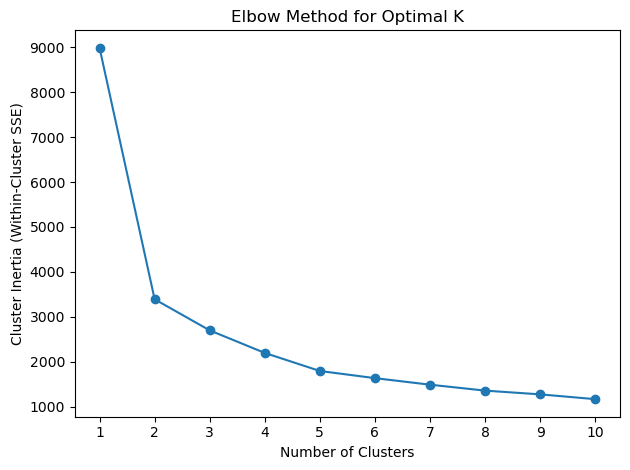

In [10]:
from sklearn.cluster import KMeans

inertias = []  

for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    inertias.append(km.inertia_)
    
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Inertia (Within-Cluster SSE)')
plt.xticks(range(1, 11))
plt.title('Elbow Method for Optimal K')
plt.tight_layout()
plt.show()

### 2.2. Silhouette Plots

silhouette_avg: 0.54


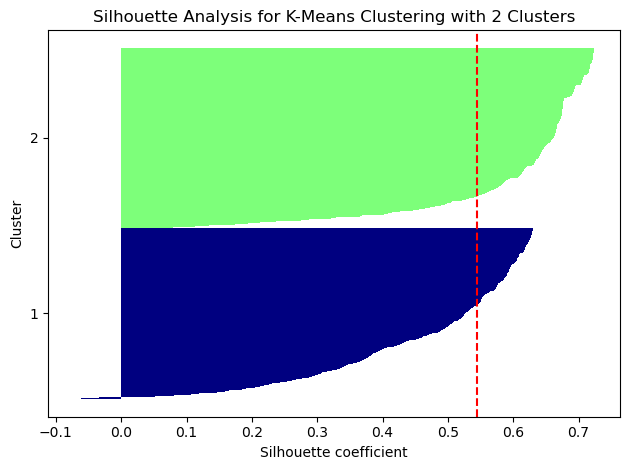

In [11]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=2,  
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)
# print(y_km)

cluster_labels = np.unique(y_km)
# print(cluster_labels)

n_clusters = cluster_labels.shape[0]

silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
# print('silhouette_vals\n', silhouette_vals)

## ------- plotting silhouette values -------

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
    
silhouette_avg = np.mean(silhouette_vals)
print(f'silhouette_avg: {silhouette_avg:.2f}')

plt.axvline(silhouette_avg, color="red", linestyle="--") # plot vertical average line

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.title('Silhouette Analysis for K-Means Clustering with 2 Clusters')

plt.tight_layout()
plt.show()

silhouette_avg: 0.43


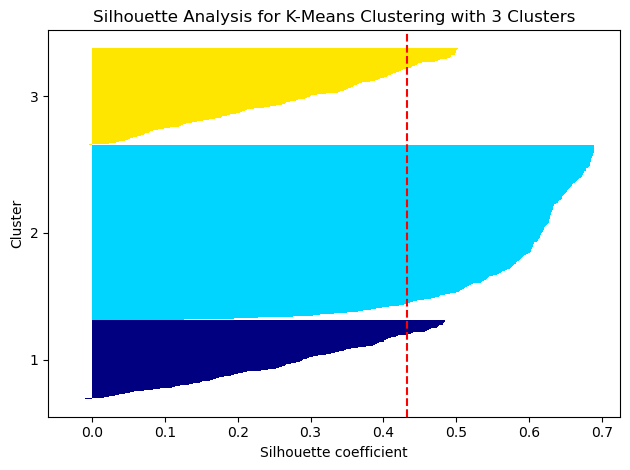

In [12]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3,  
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)
# print(y_km)

cluster_labels = np.unique(y_km)
# print(cluster_labels)

n_clusters = cluster_labels.shape[0]

silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
# print('silhouette_vals\n', silhouette_vals)

## ------- plotting silhouette values -------

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
    
silhouette_avg = np.mean(silhouette_vals)
print(f'silhouette_avg: {silhouette_avg:.2f}')

plt.axvline(silhouette_avg, color="red", linestyle="--") # plot vertical average line

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.title('Silhouette Analysis for K-Means Clustering with 3 Clusters')

plt.tight_layout()
plt.show()

silhouette_avg: 0.45


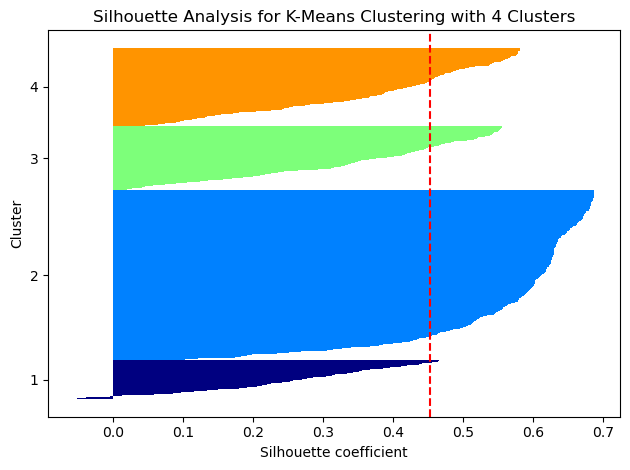

In [13]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=4,  
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)
# print(y_km)

cluster_labels = np.unique(y_km)
# print(cluster_labels)

n_clusters = cluster_labels.shape[0]

silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
# print('silhouette_vals\n', silhouette_vals)

## ------- plotting silhouette values -------

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
    
silhouette_avg = np.mean(silhouette_vals)
print(f'silhouette_avg: {silhouette_avg:.2f}')

plt.axvline(silhouette_avg, color="red", linestyle="--") # plot vertical average line

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.title('Silhouette Analysis for K-Means Clustering with 4 Clusters')

plt.tight_layout()
plt.show()

**Summary:** Based on the Elbow method, the optimal number of clusters is 2. The Silhouette analysis supports this choice, with an average Silhouette score of 0.55 for 2 clusters, which is higher than the scores for 3 clusters (0.43) and 4 clusters (0.45). Therefore, **the optimal number of clusters is 2**.

## 3. Estimate the clusters using both the K-means++ and Agglomerative Clustering techniques


### 3.1. K-means++ clustering technique

In [14]:
km_plus = KMeans(n_clusters=2, 
            init='k-means++',  
            n_init=10,      
            max_iter=300, 
            random_state=0)

y_km_plus = km_plus.fit_predict(X)

df_dropped['KMeans++'] = km_plus.labels_
df_dropped['KMeans++'].value_counts()

# print(y_km_plus)
# print(f'\nClusters:\n {km_plus.cluster_centers_}')

KMeans++
1    1024
0     976
Name: count, dtype: int64

### 3.2. Agglomerative clustering technique

In [15]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=2, 
                             affinity ='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
# print('Cluster labels: %s' % labels)

df_dropped['Agglomerative'] = ac.labels_
df_dropped['Agglomerative'].value_counts()

C:\Users\Nguyen Thu Uyen\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Agglomerative
0    1163
1     837
Name: count, dtype: int64

## 4. Provide a separate table for each clustering technique 

### 4.1. K-means++ clustering technique

In [16]:
# Drop the 'Agglomerative' column for KMeans++ analysis
df_kmeans = df_dropped.drop(columns='Agglomerative')

# Update cluster labels in the original DataFrame to "Cluster 1" and "Cluster 2"
df_kmeans['KMeans++'] = df_kmeans['KMeans++'].apply(lambda x: f'Cluster {x + 1}')

# KMeans++ Cluster Centers
kmeans_centers = df_kmeans.groupby('KMeans++').mean()
kmeans_counts = df_kmeans['KMeans++'].value_counts()

# Combine centers and counts into a separate DataFrame
kmeans_results = pd.concat([kmeans_centers, kmeans_counts], axis=1)

# Set the column names
kmeans_results.columns = list(kmeans_centers.columns) + ['Number of Customer']

# Reset the index to make 'KMeans++' a column instead of an index
kmeans_results.reset_index(inplace=True)

# Display results as a DataFrame
print("KMeans++ Cluster Centers and Number of Customers:")
kmeans_results

KMeans++ Cluster Centers and Number of Customers:


,KMeans++,Gender,Marital Status,Education,Occupation,Settlement Size,Age_scaled,Income_scaled,Number of Customer
0,Cluster 1,0.855533,0.991803,2.102459,1.214139,1.635246,0.777997,0.778479,976
1,Cluster 2,0.365234,0.032227,0.840820,0.039062,0.070312,-0.741528,-0.741987,1024


In [17]:
# Calculate mean ans standard deviation of Age and Income column
age_mean = df['Age'].mean()
age_std = df['Age'].std()
income_mean = df['Income'].mean()
income_std = df['Income'].std()

# Convert scaled Age and Income back to original values
kmeans_results['Average Age'] = ((kmeans_results['Age_scaled'] * age_std) + age_mean).round(2)
kmeans_results['Average Income'] = ((kmeans_results['Income_scaled'] * income_std) + income_mean).round(2)

# Drop the scaled columns
kmeans_results = kmeans_results.drop(columns=['Age_scaled', 'Income_scaled'])

# Reorder columns to move 'Number of Customer' to the last position
columns = [col for col in kmeans_results.columns if col != 'Number of Customer'] + ['Number of Customer']
kmeans_results = kmeans_results[columns]

# Display the updated DataFrame
print("KMeans++ Cluster Centers with Original Age and Income:")
kmeans_results

KMeans++ Cluster Centers with Original Age and Income:


,KMeans++,Gender,Marital Status,Education,Occupation,Settlement Size,Average Age,Average Income,Number of Customer
0,Cluster 1,0.855533,0.991803,2.102459,1.214139,1.635246,48.18,173469.68,976
1,Cluster 2,0.365234,0.032227,0.840820,0.039062,0.070312,33.81,103248.03,1024


### 4.2. Agglomerative clustering technique

In [18]:
# Drop the 'KMeans++' column for Agglomerative clustering analysis
df_agglomerative = df_dropped.drop(columns='KMeans++')

# Update cluster labels in the original DataFrame to "Cluster 1" and "Cluster 2"
df_agglomerative['Agglomerative'] = df_agglomerative['Agglomerative'].apply(lambda x: f'Cluster {x + 1}')

# Agglomerative clustering Centers
agglomerative_centers = df_agglomerative.groupby('Agglomerative').mean()
agglomerative_counts = df_agglomerative['Agglomerative'].value_counts()

# Combine centers and counts into a separate DataFrame
agglomerative_results = pd.concat([agglomerative_centers, agglomerative_counts], axis=1)

# Set the column names
agglomerative_results.columns = list(agglomerative_centers.columns) + ['Number of Customer']

# Reset the index to make 'Agglomerative' a column instead of an index
agglomerative_results.reset_index(inplace=True)

# Display results for Agglomerative clustering
print("\nAgglomerative Cluster Centers and Number of Customers:")
agglomerative_results


Agglomerative Cluster Centers and Number of Customers:


,Agglomerative,Gender,Marital Status,Education,Occupation,Settlement Size,Age_scaled,Income_scaled,Number of Customer
0,Cluster 1,0.774721,0.856406,1.925193,1.043852,1.384351,0.661907,0.662055,1163
1,Cluster 2,0.367981,0.005974,0.805257,0.013142,0.069295,-0.919710,-0.919916,837


In [19]:
# Calculate mean ans standard deviation of Age and Income column
age_mean = df['Age'].mean()
age_std = df['Age'].std()
income_mean = df['Income'].mean()
income_std = df['Income'].std()

# Convert scaled Age and Income back to original values
agglomerative_results['Average Age'] = ((agglomerative_results['Age_scaled'] * age_std) + age_mean).round(2)
agglomerative_results['Average Income'] = ((agglomerative_results['Income_scaled'] * income_std) + income_mean).round(2)

# Drop the scaled columns
agglomerative_results = agglomerative_results.drop(columns=['Age_scaled', 'Income_scaled'])

# Reorder columns to move 'Number of Customer' to the last position
columns = [col for col in agglomerative_results.columns if col != 'Number of Customer'] + ['Number of Customer']
agglomerative_results = agglomerative_results[columns]

# Display the updated DataFrame
print("Agglomerative Cluster Centers with Original Age and Income:")
agglomerative_results

Agglomerative Cluster Centers with Original Age and Income:


,Agglomerative,Gender,Marital Status,Education,Occupation,Settlement Size,Average Age,Average Income,Number of Customer
0,Cluster 1,0.774721,0.856406,1.925193,1.043852,1.384351,47.08,168092.73,1163
1,Cluster 2,0.367981,0.005974,0.805257,0.013142,0.069295,32.13,95030.53,837


## 5. Interpret each of the identified clusters in terms of customer attributes

### 5.1. K-means++ clustering technique

In [20]:
# Define mapping dictionaries for categorical variables
gender_mapping = {0: 'Male', 1: 'Female'}
marital_status_mapping = {0: 'Single', 1: 'Non-Single'}
education_mapping = {0: 'Other/Unknown', 1: 'High School', 2: 'University', 3: 'Graduate School'}
occupation_mapping = {0: 'Unemployed/Unskilled', 1: 'Skilled Employee/Official', 2: 'Management/Self-employed/Highly qualified employee /Officer'}
settlement_size_mapping = {0: 'Small City', 1: 'Mid-sized City', 2: 'Big City'}

# Map the rounded values to descriptive labels
kmeans_results['Gender'] = kmeans_results['Gender'].round().map(gender_mapping)
kmeans_results['Marital Status'] = kmeans_results['Marital Status'].round().map(marital_status_mapping)
kmeans_results['Education'] = kmeans_results['Education'].round().map(education_mapping)
kmeans_results['Occupation'] = kmeans_results['Occupation'].round().map(occupation_mapping)
kmeans_results['Settlement Size'] = kmeans_results['Settlement Size'].round().map(settlement_size_mapping)

# Display the transformed DataFrame
kmeans_results

,KMeans++,Gender,Marital Status,Education,Occupation,Settlement Size,Average Age,Average Income,Number of Customer
0,Cluster 1,Female,Non-Single,University,Skilled Employee/Official,Big City,48.18,173469.68,976
1,Cluster 2,Male,Single,High School,Unemployed/Unskilled,Small City,33.81,103248.03,1024


### 5.2. Agglomerative clustering technique

In [21]:
# Define mapping dictionaries for categorical variables
gender_mapping = {0: 'Male', 1: 'Female'}
marital_status_mapping = {0: 'Single', 1: 'Non-Single'}
education_mapping = {0: 'Other/Unknown', 1: 'High School', 2: 'University', 3: 'Graduate School'}
occupation_mapping = {0: 'Unemployed/Unskilled', 1: 'Skilled Employee/Official', 2: 'Management/Self-employed/Highly qualified employee /Officer'}
settlement_size_mapping = {0: 'Small City', 1: 'Mid-sized City', 2: 'Big City'}

# Map the rounded values to descriptive labels
agglomerative_results['Gender'] = agglomerative_results['Gender'].round().map(gender_mapping)
agglomerative_results['Marital Status'] = agglomerative_results['Marital Status'].round().map(marital_status_mapping)
agglomerative_results['Education'] = agglomerative_results['Education'].round().map(education_mapping)
agglomerative_results['Occupation'] = agglomerative_results['Occupation'].round().map(occupation_mapping)
agglomerative_results['Settlement Size'] = agglomerative_results['Settlement Size'].round().map(settlement_size_mapping)

# Display the transformed DataFrame
agglomerative_results

,Agglomerative,Gender,Marital Status,Education,Occupation,Settlement Size,Average Age,Average Income,Number of Customer
0,Cluster 1,Female,Non-Single,University,Skilled Employee/Official,Mid-sized City,47.08,168092.73,1163
1,Cluster 2,Male,Single,High School,Unemployed/Unskilled,Small City,32.13,95030.53,837
